# Advanced Weather Model Training (V2.0)

This notebook implements the advanced training pipeline for the Weather IoT project (Version 2.0), strictly following the `training_guide.md`.

**Structure:**
1.  **Environment Setup**: Import libraries.
2.  **Data Loading**: Load and sort hourly data.
3.  **Preprocessing & Feature Engineering**: 
    - Lag features & Rolling means for ALL targets.
    - **Cyclical Features**: Sin/Cos transformation for time.
4.  **Model Training & Comparison**: 
    - Split architecture (Regression & Classification).
    - **Comparison**: Uses a **subset** of data for faster evaluation.
5.  **Analysis & Final Training**: 
    - **Final Training**: Uses the **FULL** training dataset.
    - Individual parameter performance analysis.
6.  **Model Saving**: Save as `weather_model_v2.pkl`.
7.  **Visualization**: Actual vs Predicted (Jan 2020 Daily Aggregation).
8.  **Incremental Learning**: Impact of data size on accuracy.

### 1. Persiapan Lingkungan dan Pemuatan Pustaka

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import joblib

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor

# Set random seed
np.random.seed(42)
print("Libraries imported successfully.")

Libraries imported successfully.


### 2. Pengumpulan dan Pemuatan Data

In [31]:
# Load dataset
data_path = '../data/historical_data_hourly.csv'
df = pd.read_csv(data_path)

# Ensure timestamp is datetime and sort chronologically
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

print("Data Structure:")
df.info()
display(df.head())

Data Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219168 entries, 0 to 219167
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                219168 non-null  int64         
 1   timestamp         219168 non-null  datetime64[ns]
 2   hour              219168 non-null  int64         
 3   day               219168 non-null  int64         
 4   month             219168 non-null  int64         
 5   year              219168 non-null  int64         
 6   temp              219168 non-null  float64       
 7   humidity          219168 non-null  int64         
 8   windspeed         219168 non-null  float64       
 9   sealevelpressure  219168 non-null  float64       
 10  weather_code      219168 non-null  int64         
 11  conditions        219168 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(7), object(1)
memory usage: 20.1+ MB


,id,timestamp,hour,day,month,year,temp,humidity,windspeed,sealevelpressure,weather_code,conditions
0,0,2000-01-01 00:00:00,0,1,1,2000,21.8,98,4.0,1008.4,3,Overcast
1,1,2000-01-01 01:00:00,1,1,1,2000,21.4,99,4.0,1007.9,3,Overcast
2,2,2000-01-01 02:00:00,2,1,1,2000,21.4,98,3.2,1007.4,3,Overcast
3,3,2000-01-01 03:00:00,3,1,1,2000,21.2,99,4.6,1007.0,3,Overcast
4,4,2000-01-01 04:00:00,4,1,1,2000,21.0,99,3.6,1006.9,3,Overcast


### 3. Pra-pemrosesan Data dan Feature Engineering

In [32]:
# 1. Label Encoding for Weather Condition
# We use the original weather_code. LabelEncoder ensures they are 0..N-1 for some algorithms.
le = LabelEncoder()
df['weather_code_encoded'] = le.fit_transform(df['weather_code'])

# 2. Feature Engineering: Lag and Rolling Mean
targets_reg = ['temp', 'humidity', 'windspeed', 'sealevelpressure']

for col in targets_reg:
    # Lag Features
    df[f'{col}_lag_1'] = df[col].shift(1)
    df[f'{col}_lag_24'] = df[col].shift(24)
    
    # Rolling Mean Features (24 hour window)
    df[f'{col}_rolling_24'] = df[col].rolling(window=24).mean()

# 3. Cyclical Time Features
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Time features (Keep original for reference/other models)
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour

# 4. Handle NaN values
df_clean = df.dropna().reset_index(drop=True)

print("Data after Feature Engineering:")
display(df_clean.head())

Data after Feature Engineering:


,id,timestamp,hour,day,month,year,temp,humidity,windspeed,sealevelpressure,...,windspeed_lag_1,windspeed_lag_24,windspeed_rolling_24,sealevelpressure_lag_1,sealevelpressure_lag_24,sealevelpressure_rolling_24,hour_sin,hour_cos,month_sin,month_cos
0,24,2000-01-02 00:00:00,0,2,1,2000,22.6,98,4.4,1008.2,...,2.2,4.0,6.320833,1008.8,1008.4,1007.320833,0.000000,1.000000,0.5,0.866025
1,25,2000-01-02 01:00:00,1,2,1,2000,22.3,98,2.5,1008.1,...,4.4,4.0,6.258333,1008.2,1007.9,1007.329167,0.258819,0.965926,0.5,0.866025
2,26,2000-01-02 02:00:00,2,2,1,2000,22.3,99,1.0,1007.2,...,2.5,3.2,6.166667,1008.1,1007.4,1007.320833,0.500000,0.866025,0.5,0.866025
3,27,2000-01-02 03:00:00,3,2,1,2000,22.1,99,2.0,1006.8,...,1.0,4.6,6.058333,1007.2,1007.0,1007.312500,0.707107,0.707107,0.5,0.866025
4,28,2000-01-02 04:00:00,4,2,1,2000,21.7,99,4.6,1006.9,...,2.0,3.6,6.100000,1006.8,1006.9,1007.312500,0.866025,0.500000,0.5,0.866025


### 4. Pelatihan dan Perbandingan Model (Subset Data)

In [33]:
# Define Features and Targets
feature_cols = ['year', 'month', 'day', 'hour', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
for col in targets_reg:
    feature_cols.extend([f'{col}_lag_1', f'{col}_lag_24', f'{col}_rolling_24'])

target_class = 'weather_code_encoded'

X = df_clean[feature_cols]
y_reg = df_clean[targets_reg]
y_class = df_clean[target_class]

# --- Time Series Split Strategy ---
# 1. Full Split: 80% Train, 20% Test (Strict Temporal)
split_index = int(len(df_clean) * 0.8)

X_train_full = X.iloc[:split_index]
X_test_full = X.iloc[split_index:]

y_reg_train_full = y_reg.iloc[:split_index]
y_reg_test_full = y_reg.iloc[split_index:]

y_class_train_full = y_class.iloc[:split_index]
y_class_test_full = y_class.iloc[split_index:]

# 2. Subset Split for Comparison
subset_size = 5000
X_train_sub = X_train_full.iloc[-subset_size:]
y_reg_train_sub = y_reg_train_full.iloc[-subset_size:]
y_class_train_sub = y_class_train_full.iloc[-subset_size:]

X_test_sub = X_test_full.iloc[:1000]
y_reg_test_sub = y_reg_test_full.iloc[:1000]
y_class_test_sub = y_class_test_full.iloc[:1000]

print(f"Full Training Data: {X_train_full.shape[0]} samples")
print(f"Comparison Subset Training Data: {X_train_sub.shape[0]} samples")

# --- Regression Comparison (Using Subset) ---
reg_models = {
    'Linear Regression': LinearRegression(),
    'KNN': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
}

reg_results = []
best_reg_name = ""
best_reg_score_sub = -np.inf

print("\nComparing Regression Models (on Subset)...")
for name, model in reg_models.items():
    mor = MultiOutputRegressor(model)
    mor.fit(X_train_sub, y_reg_train_sub)
    y_pred = mor.predict(X_test_sub)
    
    r2 = r2_score(y_reg_test_sub, y_pred)
    rmse = np.sqrt(mean_squared_error(y_reg_test_sub, y_pred))
    
    reg_results.append({'Model': name, 'R2': r2, 'RMSE': rmse})
    
    if r2 > best_reg_score_sub:
        best_reg_score_sub = r2
        best_reg_name = name

display(pd.DataFrame(reg_results))
print(f"Best Regression Model (Candidate): {best_reg_name}")

# --- Classification Comparison (Using Subset) ---
# Using class_weight='balanced' to help with performance on original codes
class_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, n_jobs=-1, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, class_weight='balanced')
}

class_results = []
best_class_name = ""
best_class_score_sub = -np.inf

print("\nComparing Classification Models (on Subset)...")
for name, model in class_models.items():
    model.fit(X_train_sub, y_class_train_sub)
    y_pred = model.predict(X_test_sub)
    
    acc = accuracy_score(y_class_test_sub, y_pred)
    class_results.append({'Model': name, 'Accuracy': acc})
    
    if acc > best_class_score_sub:
        best_class_score_sub = acc
        best_class_name = name

display(pd.DataFrame(class_results))
print(f"Best Classification Model (Candidate): {best_class_name}")

Full Training Data: 175315 samples
Comparison Subset Training Data: 5000 samples

Comparing Regression Models (on Subset)...


,Model,R2,RMSE
0,Linear Regression,0.708796,3.017529
1,KNN,0.505397,2.886142
2,Decision Tree,0.661652,3.301364
3,Random Forest,0.866440,2.057208


Best Regression Model (Candidate): Random Forest

Comparing Classification Models (on Subset)...


,Model,Accuracy
0,Logistic Regression,0.020
1,Decision Tree,0.265
2,Random Forest,0.380


Best Classification Model (Candidate): Random Forest


### 5. Hyperparameter Tuning & Final Training (Full Data)

In [34]:
print("\n--- Final Training on FULL Dataset ---")
tscv = TimeSeriesSplit(n_splits=3)

# 1. Train Best Regressor on Full Data
print(f"Training {best_reg_name} on Full Data...")

if 'Random Forest' in best_reg_name:
    # Simple Grid Search for RF
    param_grid_reg = {'estimator__n_estimators': [100], 'estimator__max_depth': [20, None]}
    base_reg = MultiOutputRegressor(RandomForestRegressor(random_state=42, n_jobs=-1))
    grid_reg = GridSearchCV(base_reg, param_grid_reg, cv=tscv, scoring='r2', n_jobs=-1)
    grid_reg.fit(X_train_full, y_reg_train_full)
    best_reg_model_final = grid_reg.best_estimator_
else:
    # Fallback for other models (Linear, etc.) - just fit
    if 'Linear' in best_reg_name: base_reg = MultiOutputRegressor(LinearRegression())
    elif 'KNN' in best_reg_name: base_reg = MultiOutputRegressor(KNeighborsRegressor())
    else: base_reg = MultiOutputRegressor(DecisionTreeRegressor(random_state=42))
    
    base_reg.fit(X_train_full, y_reg_train_full)
    best_reg_model_final = base_reg

# 2. Train Best Classifier on Full Data
print(f"Training {best_class_name} on Full Data...")

if 'Random Forest' in best_class_name:
    param_grid_class = {'n_estimators': [100], 'max_depth': [20, None]}
    base_class = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
    grid_class = GridSearchCV(base_class, param_grid_class, cv=tscv, scoring='accuracy', n_jobs=-1)
    grid_class.fit(X_train_full, y_class_train_full)
    best_class_model_final = grid_class.best_estimator_
else:
    if 'Logistic' in best_class_name: base_class = LogisticRegression(max_iter=1000, n_jobs=-1, class_weight='balanced')
    else: base_class = DecisionTreeClassifier(random_state=42, class_weight='balanced')
    
    base_class.fit(X_train_full, y_class_train_full)
    best_class_model_final = base_class

print("Final Models Trained.")


--- Final Training on FULL Dataset ---
Training Random Forest on Full Data...
Training Random Forest on Full Data...
Final Models Trained.


### 6. Analisis Hasil dan Kinerja Individual Parameter

--- Individual Parameter Performance (Regression - Full Test) ---


,Parameter,R2,RMSE,MAE
0,temp,0.965897,0.544987,0.372168
1,humidity,0.954132,3.494852,2.519129
2,windspeed,0.788009,2.032036,1.512179
3,sealevelpressure,0.975061,0.281708,0.216794



--- Classification Performance (Full Test) ---
              precision    recall  f1-score   support

           0       0.38      0.23      0.29      5152
           1       0.17      0.08      0.11      3822
           2       0.10      0.02      0.03      3769
           3       0.48      0.80      0.60     17320
          51       0.39      0.43      0.41      8338
          53       0.20      0.01      0.02      2035
          55       0.00      0.00      0.00       614
          61       0.20      0.01      0.02      1251
          63       0.29      0.02      0.05      1313
          65       0.00      0.00      0.00       215

    accuracy                           0.43     43829
   macro avg       0.22      0.16      0.15     43829
weighted avg       0.36      0.43      0.36     43829



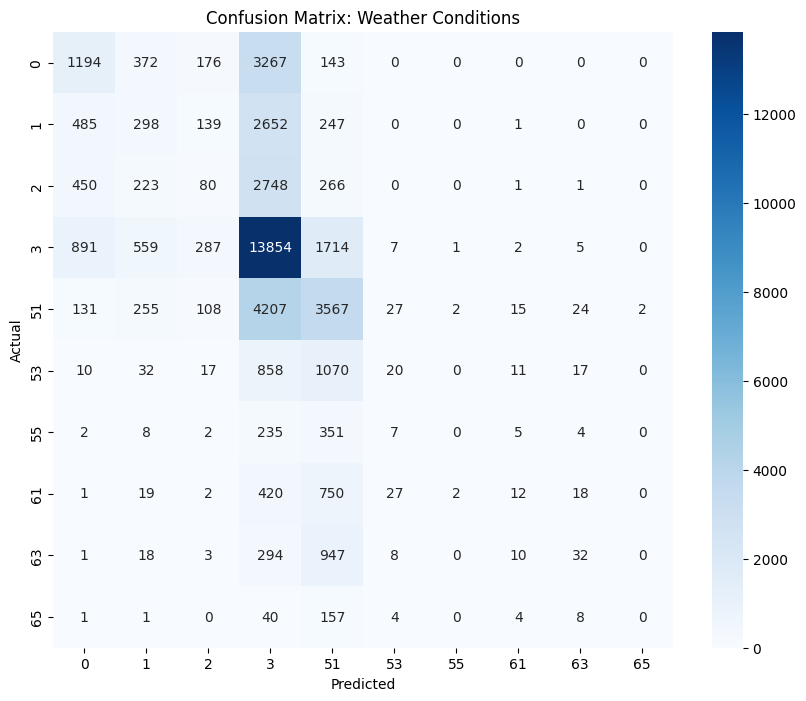

In [35]:
# Evaluate on Full Test Set
y_reg_pred_final = best_reg_model_final.predict(X_test_full)
y_class_pred_final = best_class_model_final.predict(X_test_full)

print("--- Individual Parameter Performance (Regression - Full Test) ---")
param_metrics = []
for i, col in enumerate(targets_reg):
    r2 = r2_score(y_reg_test_full.iloc[:, i], y_reg_pred_final[:, i])
    rmse = np.sqrt(mean_squared_error(y_reg_test_full.iloc[:, i], y_reg_pred_final[:, i]))
    mae = mean_absolute_error(y_reg_test_full.iloc[:, i], y_reg_pred_final[:, i])
    param_metrics.append({'Parameter': col, 'R2': r2, 'RMSE': rmse, 'MAE': mae})

display(pd.DataFrame(param_metrics))

print("\n--- Classification Performance (Full Test) ---")
print(classification_report(y_class_test_full, y_class_pred_final, target_names=le.classes_.astype(str)))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_class_test_full, y_class_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix: Weather Conditions')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 7. Penyimpanan Model Terbaik

In [36]:
# Save artifacts
artifacts = {
    'regressor': best_reg_model_final,
    'classifier': best_class_model_final,
    'label_encoder': le,
    'features': feature_cols,
    'targets_reg': targets_reg,
    'version': '2.0'
}

save_dir = '../models'
os.makedirs(save_dir, exist_ok=True)
filename = os.path.join(save_dir, 'weather_model_v2.pkl')

with open(filename, 'wb') as f:
    pickle.dump(artifacts, f)

print(f"Model saved to {filename}")

Model saved to ../models\weather_model_v2.pkl


### 8. Visualisasi Perbandingan Aktual vs. Prediksi (Januari 2020)

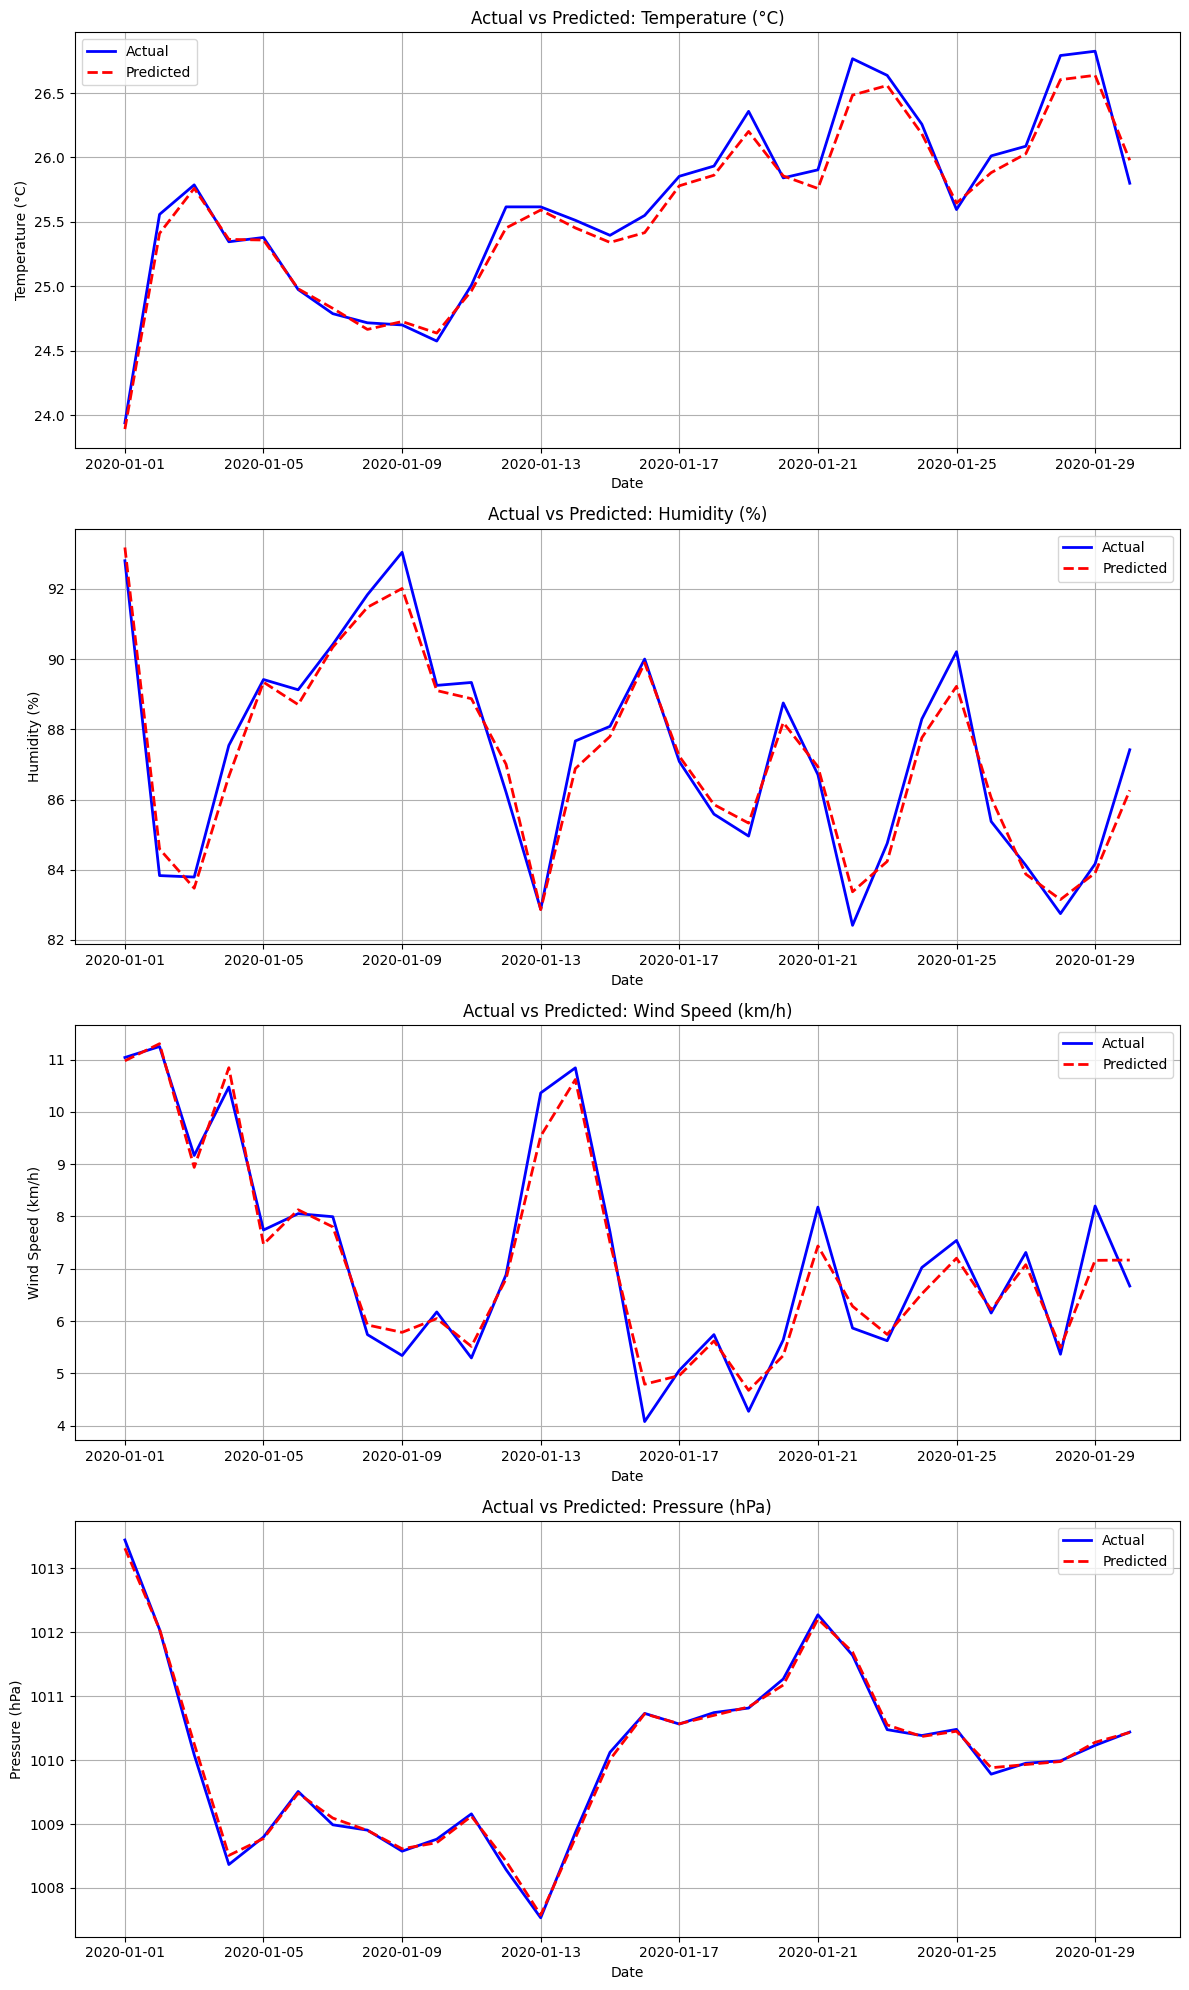

In [37]:
# Filter data for visualization (e.g., first 30 days of test data)
test_df = df_clean.iloc[X_test_full.index].copy()
test_df['pred_temp'] = y_reg_pred_final[:, 0]
test_df['pred_humidity'] = y_reg_pred_final[:, 1]
test_df['pred_windspeed'] = y_reg_pred_final[:, 2]
test_df['pred_pressure'] = y_reg_pred_final[:, 3]

# Resample to Daily Mean for cleaner plots
daily_df = test_df.set_index('timestamp').resample('D').mean(numeric_only=True)

# Plotting
fig, axes = plt.subplots(4, 1, figsize=(12, 20))

params = [
    ('temp', 'pred_temp', 'Temperature (°C)'),
    ('humidity', 'pred_humidity', 'Humidity (%)'),
    ('windspeed', 'pred_windspeed', 'Wind Speed (km/h)'),
    ('sealevelpressure', 'pred_pressure', 'Pressure (hPa)')
]

for i, (actual, pred, label) in enumerate(params):
    ax = axes[i]
    # Plot only first 30 days
    plot_data = daily_df.iloc[:30]
    
    ax.plot(plot_data.index, plot_data[actual], label='Actual', color='blue', linewidth=2)
    ax.plot(plot_data.index, plot_data[pred], label='Predicted', color='red', linestyle='--', linewidth=2)
    ax.set_title(f'Actual vs Predicted: {label}')
    ax.set_xlabel('Date')
    ax.set_ylabel(label)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

### 9. Visualisasi Dampak Data Inkremental

Simulating Incremental Learning...


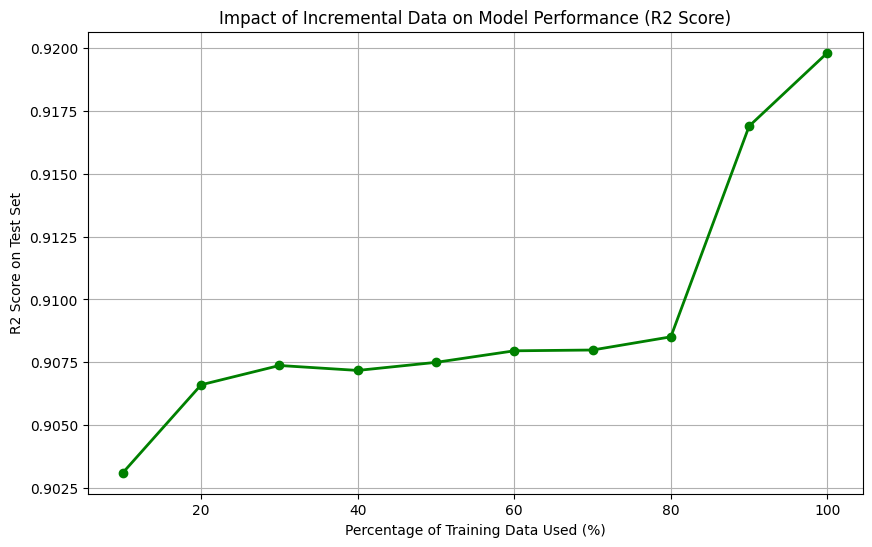

In [38]:
# Simulate Incremental Learning using Full Training Data
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
r2_scores = []

print("Simulating Incremental Learning...")
for frac in fractions:
    # Use a fraction of the full training data (chronologically)
    subset_size = int(len(X_train_full) * frac)
    X_subset = X_train_full.iloc[:subset_size]
    y_subset = y_reg_train_full.iloc[:subset_size]
    
    # Train model on subset (using best regressor type)
    if 'Random Forest' in best_reg_name:
        model = MultiOutputRegressor(RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1))
    else:
        model = MultiOutputRegressor(LinearRegression())
        
    model.fit(X_subset, y_subset)
    
    # Evaluate on full test set
    y_pred_subset = model.predict(X_test_full)
    score = r2_score(y_reg_test_full, y_pred_subset)
    r2_scores.append(score)

# Plot Trend
plt.figure(figsize=(10, 6))
plt.plot(np.array(fractions) * 100, r2_scores, marker='o', color='green', linewidth=2)
plt.title('Impact of Incremental Data on Model Performance (R2 Score)')
plt.xlabel('Percentage of Training Data Used (%)')
plt.ylabel('R2 Score on Test Set')
plt.grid(True)
plt.show()